# Liver analysis

**Author**: Alma Andersson<br>
**Description**:<br>

Joint spatial analysis of the entire dataset. The analysis is separated into three parts

- Data Loading and processing
- Feature by distance analysis
- Classification of structures

### Data loading and processing
A brief section loading and processing the data.


### Feature by distance analysis
Here, expression as a function of distance (_feature by distance_) is exemplified, as well as the slightly modified variant where the log-ratio between distances to two different structure classes (here portal and central veins) is examined.


### Classification
This section illustrates how the type of a vein can be predicted based on its neighborhood expression profile (NEP). Included in the analysis is the creation of NEPs, a two step procedure where a neighborhood is first identified, from which a weighted gene expression (by distance) is then assembled. Once the NEPs are formed, a _logistic regression_ model is trained to predict vein type based on the NEP. Cross validation is also implemented to assess performance.


<hr>

### Load libraries

Load data the necessary packages and data for the analysis, also specify certain constants which will be used throughout the analysis.

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
import anndata as ad

from skmisc.loess import loess

import os
import os.path as osp
from os import listdir

import matplotlib.pyplot as plt
from matplotlib import rcParams

from PIL import Image

from functools import reduce

from scipy.spatial.distance import cdist

from hepaquery.structures import VeinData, Model
import hepaquery.visual as viz
import hepaquery.utils as ut

import re
import datetime


In [3]:
rcParams["figure.facecolor"] = "white"

### Global Variables

Here certain global variables are set, which will be used to save output and load data. A brief explanation is provided below:

- TAG : Unique identifier for the analysis. All results will be saved in a folder called "TAG-analysis" within the res-folder.
- REPO\_DIR : Path to the repository directory, only change this if files are moved around.
- DATA_DIR : Path to the data being loaded.
- GENE_LIST_DIR : Directory to lists of genes
- SCALE_FACTOR : Scaling factor between pixels to $\mu m$

In [4]:

TAG = re.sub(":| |-|\\.|","",str(datetime.datetime.today()))
TAG = TAG + "-analysis"

REPO_DIR = osp.dirname(osp.abspath(os.getcwd()))
DATA_DIR = osp.join(REPO_DIR,"data/h5ad-cca")
RESULTS_DIR = osp.join(REPO_DIR,"res",TAG)

if not osp.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)
    
GENE_LIST_DIR = osp.join(REPO_DIR,"data/gene-lists/marker-genes")


SCALE_FACTOR = 0.26

SAVE_RESULTS = False

In [5]:
# Get data paths
PTHS = list(filter(lambda x: x.endswith("h5ad"),os.listdir(DATA_DIR)))
PTHS = {p:osp.join(DATA_DIR,p) for p in PTHS }

data_set = {n:ad.read_h5ad(p) for n,p in PTHS.items()}
new_names = {k:d.uns["sample"] + "-" + d.uns["replicate"] for k,d in data_set.items()}
data_set = dict((new_names[k],d) for k,d in data_set.items())
    
data_set

{'CN65-C1': AnnData object with n_obs × n_vars = 647 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN73-D1': AnnData object with n_obs × n_vars = 684 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN65-C2': AnnData object with n_obs × n_vars = 626 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN16-E1': AnnData object with n_obs × n_vars = 1348 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN73-C1': AnnData object with n_obs × n_vars = 673 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 's

In [6]:
exclude = ["CN65-C1","CN65-C2","CN16-D1", "CN16-E1"]

for ex in exclude:
    data_set.pop(ex)

data_set

{'CN73-D1': AnnData object with n_obs × n_vars = 684 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN73-C1': AnnData object with n_obs × n_vars = 673 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN65-D1': AnnData object with n_obs × n_vars = 663 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN16-D2': AnnData object with n_obs × n_vars = 487 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN65-D2': AnnData object with n_obs × n_vars = 629 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sa

In [7]:
use_short_filter = True

pths = listdir(osp.join(GENE_LIST_DIR,"sc-halpern"))
if use_short_filter:
    pths = list(filter(lambda x: "short" in x,pths))
else:
    pths = list(filter(lambda x: "short" not in x,pths))
# read gene lists
genes = dict()

for filename in pths:
    name = '.'.join(filename.split(".")[0:-1])
    with open(osp.join(GENE_LIST_DIR,"sc-halpern",filename),"r+") as f:
        _gs = f.readlines()
        _gs = [x.replace("\n","") for x in _gs]
        genes.update({name:_gs})
        
# create an additional entry called "all" by joining 
# all existing lists
genes["all"] = reduce(lambda x,y : x + y,list(genes.values()))

In [8]:
genes["all"]

['Thbd', 'Cdh13', 'Efnb2', 'Ltbp4', 'Adamtsl2', 'Sox4', 'Ngfr', 'Tagln']

Visualize the data to make sure everything looks as expected

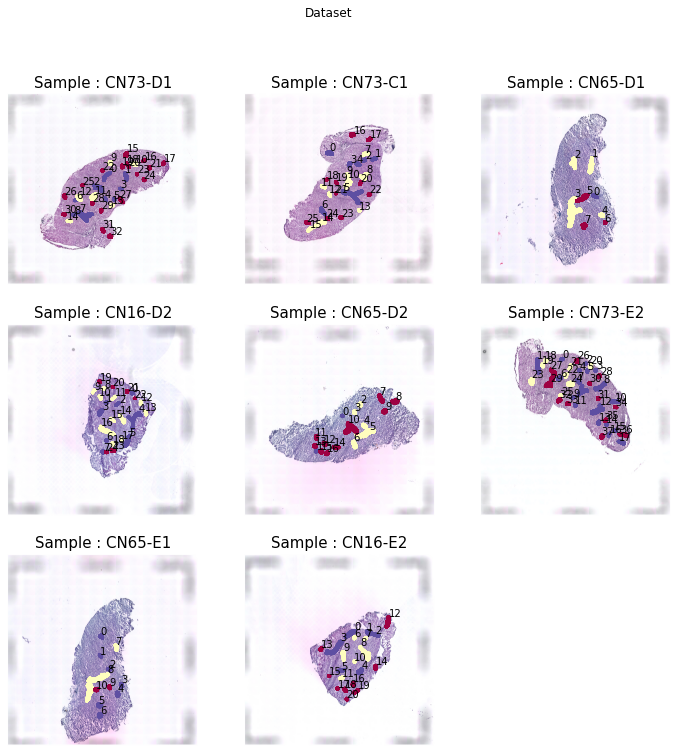

In [9]:
n_veins = len(data_set)
spot_size = 20
side_size =4

fig,ax = viz.get_figure(n_veins,n_cols = 3, side_size = side_size)

for k,(sample_id,data) in enumerate(data_set.items()):
    
    viz.plot_veins(ax[k],data,
                   show_image=True,
                   show_id=True)
    
    ax[k].set_title("Sample : {}".format(sample_id),
                   fontsize = 15,
                   )
    
fig.suptitle("Dataset")
if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,"dataset-display.png"))
plt.show()

In [10]:
for sample,data in data_set.items():
    log_ratio = np.log(data.obsm["vein_distances"].dist_type_central) -\
    np.log(data.obsm["vein_distances"].dist_type_portal)
    data_set[sample].obsm["vein_distances"]["log(central/portal)"] = log_ratio

/home/alma/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:123: UserWarning: Pandas requires version '2.6.8' or newer of 'numexpr' (version '2.6.6' currently installed).
  warnings.warn(msg, UserWarning)


## Analysis : Expression by distance

Model gene expression as a function of the distance to the nearest gene. We use loess regression to get an approximation of the curve that describe the trends in the data. Envelopes (blue) represent 1 standard error.

In [11]:
genes

{'LEC_short': ['Thbd',
  'Cdh13',
  'Efnb2',
  'Ltbp4',
  'Adamtsl2',
  'Sox4',
  'Ngfr',
  'Tagln'],
 'all': ['Thbd',
  'Cdh13',
  'Efnb2',
  'Ltbp4',
  'Adamtsl2',
  'Sox4',
  'Ngfr',
  'Tagln']}

In [12]:
for gene in genes["all"]:
    if gene in data_set["CN73-D1"].var.gene:
        print(gene)
        print(data_set["CN73-D1"].obs_vector(gene).sum())

Thbd
27.555988
Ltbp4
69.44605
Adamtsl2
0.0
Sox4
0.0
Ngfr
0.0
Tagln
23.263575


can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
no expression of Adamtsl2
no expression of Adamtsl2
no expression of Adamtsl2
no expression of Adamtsl2
no expression of Adamtsl2
no expression of Adamtsl2
no expression of Sox4
no expression of Sox4
no expression of Sox4
no expression of Sox4
no expression of Sox4
no expression of Sox4
no expression of Ngfr
no expression of Ngfr
no expression of Ngfr
no expression of Ngfr
no expression of Ngfr
no expression of Ngfr
no expression of Ngfr
no expression 

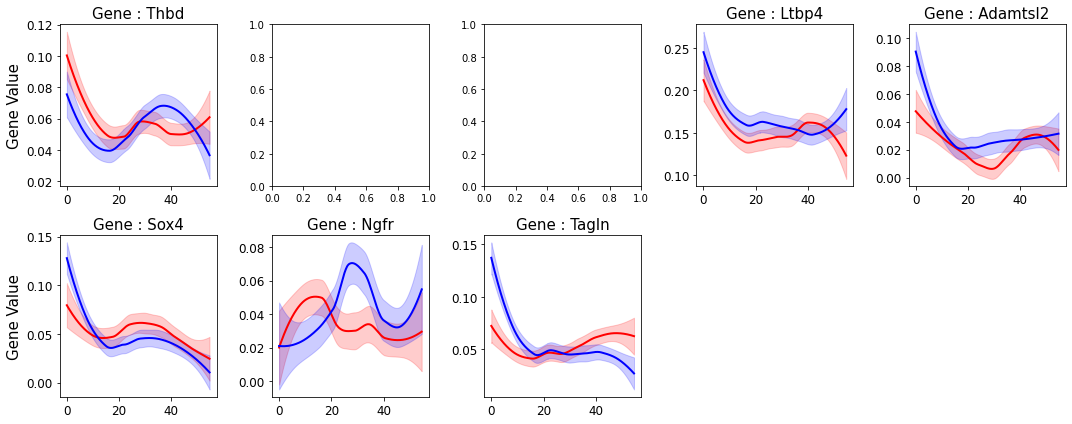

In [15]:

# set vein type to plot
vein_type = "all"

# set to true if plots should share y-axis
share_y = False

# set within which distance from the vein
# gene expresssion should be assessed; could
# be same as RADIUS
dist_thrs = 210

# which genes to be assessed
vein_genes = genes["all"]

#define how many columns to plot
n_cols = 5 

# distance values to use

colormap = dict(central = {"envelope":"red",
                           "fitted":"red",
                           "background":"red"},
               portal = {"envelope":"blue",
                         "fitted":"blue",
                         "background":"blue"},
               )

fig,ax = viz.get_figure(len(vein_genes),
                       n_cols = n_cols,
                       side_size = 3,
                      )

# iterate over each gene
for k,gene in enumerate(vein_genes):
    
    
    for vt in ["central", "portal"]:

        xs = np.array([])
        ys = np.array([])
        
        for data in data_set.values():
            if gene not in data.var.gene.values:
                print("can't find {}".format(gene))
                continue
            elif not data.obs_vector(gene).sum() > 1:
                print("no expression of {}".format(gene))
                continue
            
            
            min_dist = data.obsm["vein_distances"]["dist_type_" + vt].values
            xs = np.append(xs,min_dist)
            ys = np.append(ys,data.obs_vector(gene))
        
        if len(xs) > 0:
            smoothed = ut.smooth_fit(xs,ys,dist_thrs=dist_thrs)
            viz.plot_expression_by_distance(ax[k],
                                            data = smoothed,
                                            curve_label = vt,
                                            color_scheme = colormap[vt],
                                            include_background = False,
                                            feature_type = "Gene",
                                            feature = gene,
                                            distance_scale_factor = SCALE_FACTOR,
                                            title_fontsize = 18,
                                            label_fontsize = 15,
                                            tick_fontsize = 12,
                                            distance_unit = "um",
                                          )
            ax[k].set_xlabel("")
        if k % n_cols != 0: ax[k].set_ylabel("")

fig.tight_layout()

if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,
                         "feature-by-distance.svg"),
                facecolor = "white",
                dpi = 600)
    
plt.show()

In [1]:
smoothed

NameError: name 'smoothed' is not defined

can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Cdh13
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
can't find Efnb2
no expression of Adamtsl2
no expression of Adamtsl2
no expression of Adamtsl2
no expression of Sox4
no expression of Sox4
no expression of Sox4
no expression of Ngfr
no expression of Ngfr
no expression of Ngfr
no expression of Ngfr
no expression of Ngfr
no expression of Ngfr


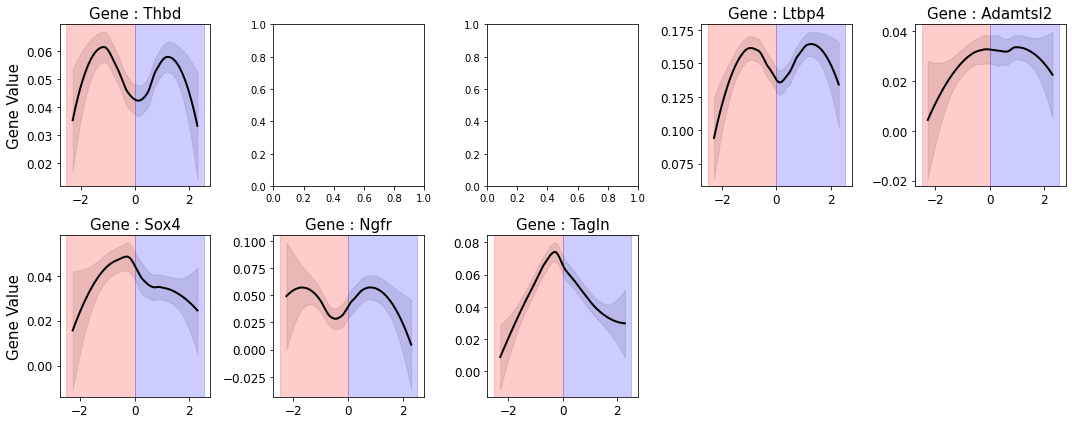

In [16]:

# set vein type to plot
vein_type = "all"

# set to true if plots should share y-axis
share_y = False

# set within which distance from the vein
# gene expresssion should be assessed; could
# be same as RADIUS
dist_thrs = np.log(10)

# which genes to be assessed
vein_genes = genes["all"]


fig,ax = viz.get_figure(n_elements=len(vein_genes),
                        n_cols = 5,
                       side_size = 3,
                       )
# --- plot settings

# iterate over each gene
#for k,gene in enumerate(vein_genes):
for k,gene in enumerate(vein_genes):

    xs = np.array([])
    ys = np.array([])

    for data in data_set.values():
        if gene not in data.var.gene.values:
            print("can't find {}".format(gene))
            continue
        elif not data.obs_vector(gene).sum() > 1:
            print("no expression of {}".format(gene))
            continue
                
        dist = data.obsm["vein_distances"]["log(central/portal)"].values
        xs = np.append(xs,dist)
        ys = np.append(ys,data.obs_vector(gene))

    if len(xs) > 0:
        smoothed = ut.smooth_fit(xs,ys,dist_thrs=dist_thrs)
        viz.plot_expression_by_distance(ax[k],
                                       smoothed,
                                       flavor ="logodds",
                                       feature = gene,
                                       color_scheme = {"envelope":"gray"},
                                       include_background = False,
                                       feature_type = "Gene",
                                       title_fontsize = 18,
                                       label_fontsize = 15,
                                       tick_fontsize = 12,
                                      )
        ax[k].set_xlabel("")
        if k % n_cols != 0: ax[k].set_ylabel("")
        
fig.tight_layout()
if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,"feature-by-distance-ratio.svg"),
                facecolor = "white", dpi = 600)
plt.show()

## Analysis : Classification

Begin by assembling representative (mean expression) vectors for neighborhoods around respective vein type and each individual vein. Then proceed to train a predictor (Logistic Regression) and see how it performs on the given data (this is just a prototype).

### Prepare data
Create the necessary mean expression profiles

In [ ]:
vein_data = VeinData(data_set = data_set,
                    radius = 80,
                    use_genes = genes["all"],
                    weight_by_distance = True,
                    sigma = 20,
                    verbose = True,
                   )

model = Model(vein_data,
              verbose=False)


### Train and Predict with classifier

use the `LogisticRegression` module from `sklearn` to create a classifier (binary classification into portal and central veins). We use a l2 penalty to reduce the extent of overfitting and also prevent the weights to blow up.

In [ ]:
k = 1
exclude_class = "unknown"
validate_by = "sample"

results = model.cross_validation(k=k,
                                 exclude_class=exclude_class,
                                 by = validate_by,
                                 verbose = False,
                                 )
display(results)
print("Average Accuracy {}".format(results["accuracy"].mean()))

if SAVE_RESULTS:
    if isinstance(exclude_class,list):
        exclude_class = "_".join(exclude_class)
    
    basename = f'CV-{k}-EX-{exclude_class}-BY-{validate_by}.tsv'
    results.to_csv(osp.join(RESULTS_DIR,basename),
                   sep = "\t",
                
                  )


In [ ]:
fig,ax = viz.visualize_prediction_result(results)

if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,basename.replace("tsv","png")),
               facecolor = "white",
               )


Finally we can visualize the prediction on the tissue, showing the predicted and true labels for respective vein

In [ ]:
k = 1
exclude_class = "unknown"
validate_by = "individual"

results = model.cross_validation(k=1,
                                 exclude_class="unknown",
                                 by = "individual",
                                 verbose = False,
                                 )
if SAVE_RESULTS:
    if isinstance(exclude_class,list):
        exclude_class = "_".join(exclude_class)
    
    basename = f'CV-{k}-EX-{exclude_class}-BY-{validate_by}.tsv'
    results.to_csv(osp.join(RESULTS_DIR,basename),
                   sep = "\t",
                  )

display(results)

In [ ]:
fig,ax = viz.visualize_prediction_result(results)
if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,basename.replace("tsv","png")),
               facecolor = "white",
               )

## Prediction on unknown veins

In [ ]:
model.fit(train_on = "all",
          verbose=True,
          exclude_class="unknown")

predict = model.predict(predict_on="all",
                        exclude_class=["portal","central"],
                        return_probs = True,
                       )


In [ ]:
#only print veins of interest (CN73-D1_30 and CN73-D1_25)
for vein_id in ["CN73-D1_30", "CN73-D1_25"]:
    pc,pp = predict.loc[vein_id,:]
    print("Vein : {} | P(central) : {} | P(portal) : {}".format(vein_id,
                                                                pc,
                                                                pp,
                                                               ))
    fig,ax = viz.get_figure(n_elements=len(vein_genes),
                          n_cols = 5,
                           side_size = 3,
                          )
    
    sample_id = vein_id.split("_")[0]
    
    crd = data_set[sample_id].obs[["x","y"]].values

    dists = vein_data.get_distance_to_vein(crd = crd,
                                           vein_id = vein_id)

    for k,gene in enumerate(vein_genes):
        expr = data_set[sample_id].obs_vector(gene)
        smoothed = ut.smooth_fit(dists,expr,dist_thrs=100)
        
        viz.plot_expression_by_distance(ax[k],
                                       smoothed,
                                       feature = gene,
                                       feature_type = "Gene",
                                       title_fontsize = 18,
                                       label_fontsize = 15,
                                       tick_fontsize = 12,
                                      )
    ax[k].set_xlabel("")
    if k % n_cols != 0: ax[k].set_ylabel("")
    
    fig.tight_layout()
    if SAVE_RESULTS:
        PRED_DIR = osp.join(RESULTS_DIR,"preds")
        if not osp.exists(PRED_DIR):
            os.mkdir(PRED_DIR)
            
        fig.savefig(osp.join(PRED_DIR,f"Vein-{vein_id}-Pc-{pc:0.3f}-Pp-{pp:0.3f}.svg",
                            ),
                    facecolor = "white", dpi = 600)
    
    plt.show()
        
    

In [ ]:
predict_all = model.predict(predict_on="all",
                            return_probs = False,
                        )

if SAVE_RESULTS:
    predict_all.to_csv(osp.join(RESULTS_DIR,"predict-all-hard.tsv"),sep = "\t")
    
display(predict_all)

In [ ]:
# instantiate plot
fig,ax = plt.subplots(len(data_set),2,
                      figsize = (4 * 2,4 * len(data_set)))

cmap = {"central":"red",
        "portal":"blue",
        "unknown":"green"}


for k,sample_id in enumerate(data_set.keys()):
  
    # convert predicted type to vector
    # with label for each pixel
    
    true_color = data_set[sample_id].uns["mask"].type.map(cmap).values.flatten()
    pred_color = data_set[sample_id].uns["mask"].type.map(cmap).values.flatten()
    
    idxs = data_set[sample_id].uns["mask"].id.values
    
    for idx in np.unique(idxs):
        sel = idxs == idx
        vein_id = sample_id + "_" + str(idx)
        pred_color[sel] = cmap[predict_all.loc[vein_id].values[0]]
        
    
    viz.plot_veins(ax[k,0],
                  data_set[sample_id],
                  alternative_colors = true_color,
                  show_image = True,
                  show_id = True,
                 )
    
    viz.plot_veins(ax[k,1],
                  data_set[sample_id],
                  alternative_colors = pred_color,
                  show_image = True,
                  show_id = True,
                 )
    
    # set titles
    ax[k,0].set_title("True",
                    fontsize = 20,)
    ax[k,1].set_title("Predicted",
                    fontsize = 20,)
    
    ax[k,0].set_ylabel(sample_id,
                       fontsize = 20)


if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,"predict-all-hard.png"),
                facecolor = "white")
    
plt.show()